# Other Manufacturing Sources Profiling
_Profiling attempts to distinguish the different potential sources of PFAS attribution to our private well supplies. The way that we can create a profile of a potential source is by ingesting sampling results (that are most directly attributable to a specific source) through a feature reduction or clustering method to build a vector/model that exemplifies that source._ 

**PCA** is used in this notebook to build a profile of the potential sources.
**HC (or HCA)** (hierarchical clustering analysis) is used in conjunction with PCA to build profile(s).

Potential Sources & attributable information:
* Residential Profile: Wastewater/sludge data from wastewater treatment systems (in a separate notebook)
  (residential_profiling.ipynb)
* AFFF Profile: AFFF lab reports (AFFF_profiling.ipynb)
* Airport Profile:
* Other manufacturing sources: Disposal site groundwater supplies (THIS notebook)
    * Each eigenvector may indicate a different potential industry/manufacturing source
    * Additional spatial inference may need to be employed to identify the types of sources attributed to each eigenvector
    
EDA is used to understand the general trends of the profiles to intuitively understand the results of the analysis. Geospatial inferencing is additionally employed to further understand the landscape of the potential source effects.

****

Questions to consider:

- How will we use spatial inference to infer the eigenvectors?
    * Use maps and general distances to understand potential impacts. Possibly highlight a few places with high PFAS levels and nearby contaminant sources.
    * Maybe only use for Hierarchical clustering
    
Notes/Assumptions/Decisions about analysis
* Matrix and dilution factors need to be accounted for in AFFF data before normalization.
* Partition liquid v. water in normalization

***

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Import Data
* Data has already been imputed via imputation pipeline

In [24]:
other_df = pd.read_csv('../../../data/modeling_data/source_attribution/other_source.csv')

In [3]:
pfas6 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS6']]
pfas6 = pfas6[~(pfas6['PFAS6'].isna())]['Acronym']

In [4]:
pfas_vars = utils.get_pfas_vars(df = other_df,
                                pfas18 = pfas6)

Normalize. Make sure the ingested data is z-score normalized

In [5]:
# other_df.columns

In [6]:
other_df_eda = utils.normalize_over_partitions(df = other_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Units',
                                              scaler_fn = 'MinMax')

## EDA

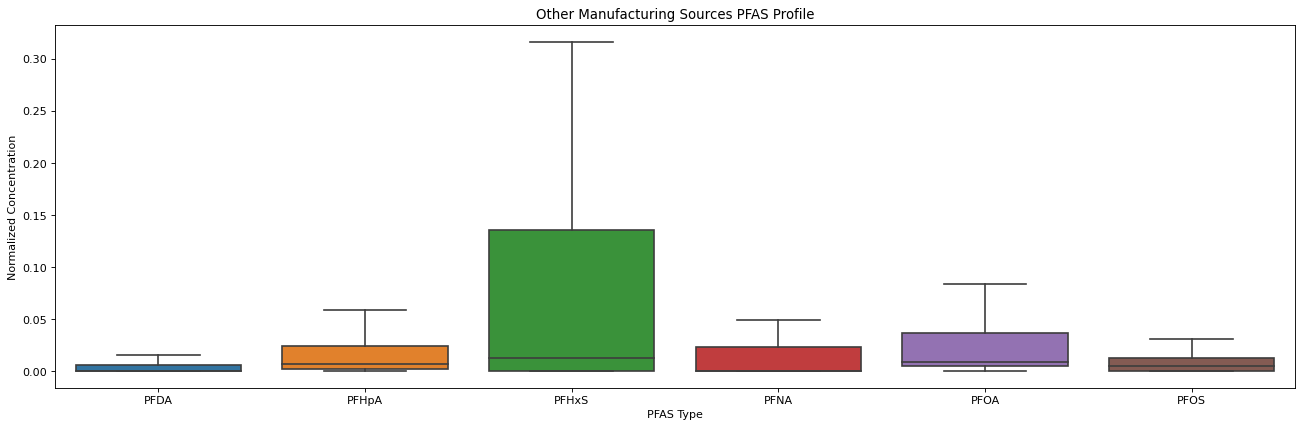

In [7]:
# Should this be in molecular weight order?? - Easier to compare across different sources/samples

plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing Sources PFAS Profile')

# pd.melt(other_df[pfas_vars])
sns.boxplot(x="variable", y="value", data=pd.melt(other_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

## PCA
* We should use enough eigenvectors to explain 70% of the variance, or up to 2 eigenvectors for each potential source.
* 18 v. 6 analysis: https://www.youtube.com/watch?v=d588GFOEnP0

In [8]:
from sklearn.decomposition import PCA

In [9]:
other_df = utils.normalize_over_partitions(df = other_df, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Units',
                                          scaler_fn = 'Zscore')

In [10]:
other_df.head(5)

,Unnamed: 0,report,date_sampled,sample_id,lab,Matrix,Units,NEtFOSAA,NMeFOSAA,PFBS,...,PFDoA,PFHpA,PFHxA,PFHxS,PFNA,PFOA,PFOS,PFTA,PFTrDA,PFUnA
0,0,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:12,01G,Alpha,Dw,ng/l,0.645,0.2765,0.1305,...,0.298,-0.249675,1.180,-0.274206,-0.280547,-0.283648,1.274752,0.19875,0.2335,0.197
1,1,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:29,02G,Alpha,Dw,ng/l,0.258,0.2765,3.0800,...,0.298,-0.281517,0.914,-0.264395,-0.298794,-0.378051,-0.302491,0.19875,0.2335,0.197
2,2,1-0021230 - Lanesborough - Document_ID_587486 ...,12/27/18 10:10,PROPERTY CS,Alpha,Dw,ng/l,0.258,0.2765,0.1305,...,0.298,-0.170025,12.700,-0.287487,-0.298794,-0.359590,-0.327860,0.19875,0.2335,0.197
3,3,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 10:32,TW-7,Alpha,Water,ng/l,0.258,0.2765,1.9700,...,0.298,-0.273604,1.840,-0.264232,-0.263783,-0.365831,-0.140237,0.19875,0.2335,0.197
4,4,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:12,01G,Alpha,Water,ng/l,0.258,0.2765,0.1305,...,0.298,-0.250187,1.290,-0.280169,-0.291186,-0.285221,1.261699,0.19875,0.2335,0.197


In [11]:
# Need to remove remaining NaNs. Not sure how to do that yet. Might need to substitute
# known reporting limit for that lab for the particular compound? Dropping columns with NaNs will eliminate many of
# the compounds and result in errors later on.
# residential_df.dropna(inplace = True)
# other_df.dropna(axis = 'columns', inplace = True)
# other_df.fillna(value = 0.0, inplace = True)

In [12]:
# other_df.head(10)

In [13]:
# residential_df = afff_df

# pca = PCA()
# pca
pca = PCA(n_components=6)
Principal_components=pca.fit_transform(other_df[pfas_vars])
# print(Principal_components.shape)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])

component_matrix = pca.components_
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [14]:
import pickle as pk
# Save PCA for source attribution
# pk.dump(pca, open("./results/other_pfas6_pca.pkl", "wb"))

### Visualization

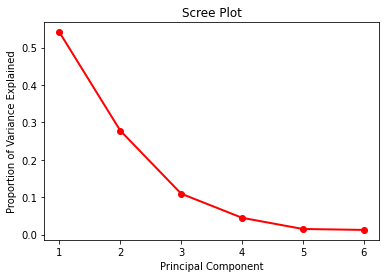

In [15]:
# Examine PCA results - scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [16]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.54085639 0.27780159 0.10924853 0.04479735 0.01490327 0.01239286]
Cumulative Prop. Variance Explained:  [0.54085639 0.81865798 0.92790651 0.97270386 0.98760714 1.        ]


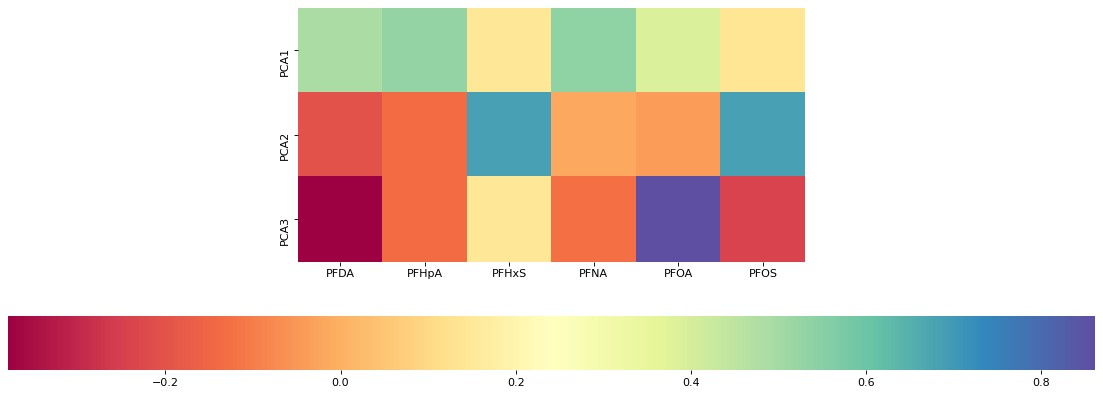

In [17]:
# look at correlation matrix of components
plt.figure(figsize=(20, 6), dpi=80)

ax = sns.heatmap(component_matrix[:3],
                 cmap='Spectral',
                 yticklabels=[ "PCA"+str(x) for x in range(1,3+1)],
                 xticklabels=list(other_df[pfas_vars].columns),
                 cbar_kws={"orientation": "horizontal"})

ax.set_aspect("equal")

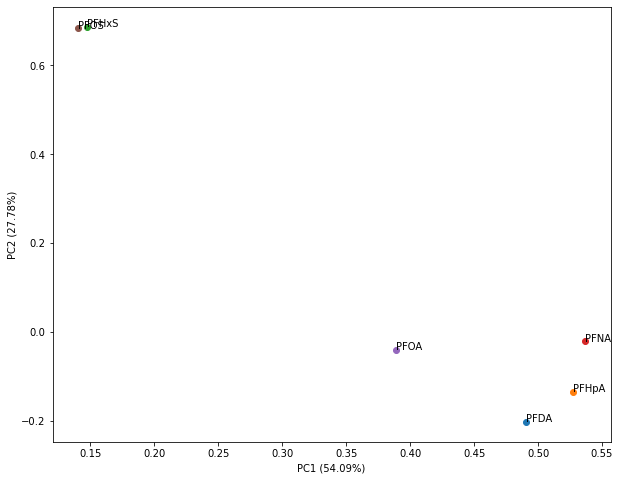

In [18]:
utils.pcaplot(x=component_matrix[0], y=component_matrix[1], labels=other_df[pfas_vars].columns.values, 
    var1=round(pca.explained_variance_ratio_[0]*100, 2),
    var2=round(pca.explained_variance_ratio_[1]*100, 2),
             dim=(10, 8))

In [19]:
# 3D
# cluster.pcaplot(x=loadings[0], y=loadings[1], z=loadings[2],  labels=df.columns.values, 
#     var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
#     var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [53]:
pca_df_x = pca_df.iloc[:,0]
pca_df_y = pca_df.iloc[:,1]
pca_df_z = pca_df.iloc[:,2]
scalex = 1.0/(pca_df_x.max() - pca_df_x.min())
scaley = 1.0/(pca_df_y.max() - pca_df_y.min())
scalez = 1.0/(pca_df_z.max() - pca_df_z.min())

In [54]:
other_df['RTN'] = other_df['report'].str[:9]

In [55]:
other_df['RTN'].unique()

array(['1-0021230', '2-0020439', '2-0021116', '2-0021349', '2-0021383',
       '2-0021446', '2-0021455', '2-0021541', '2-0021682', '3-0036649',
       '3-0036899', '3-0036926', '4-0028330'], dtype=object)

In [56]:
pca_df['RTN'] = other_df['RTN']

1-0021230
PC 1 Score Summary Statistics : count    15.000000
mean     -0.043471
std       0.008260
min      -0.049195
25%      -0.049181
50%      -0.048018
75%      -0.042582
max      -0.025945
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    15.000000
mean     -0.011478
std       0.034346
min      -0.031429
25%      -0.029856
50%      -0.028743
75%      -0.009843
max       0.069587
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    15.000000
mean     -0.025842
std       0.014210
min      -0.059925
25%      -0.022724
50%      -0.020689
75%      -0.020437
max      -0.010846
Name: PC 3, dtype: float64


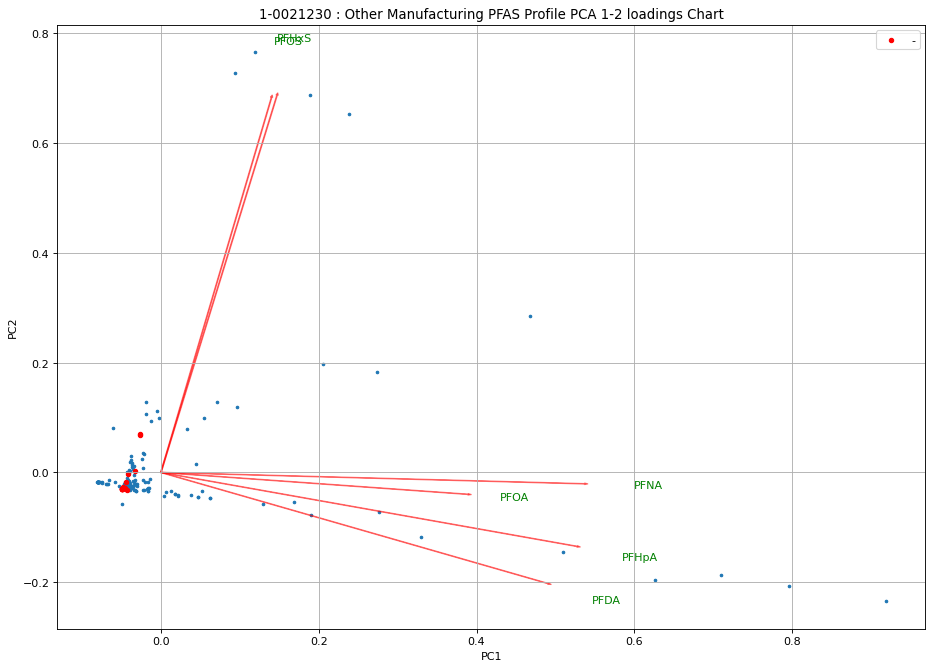

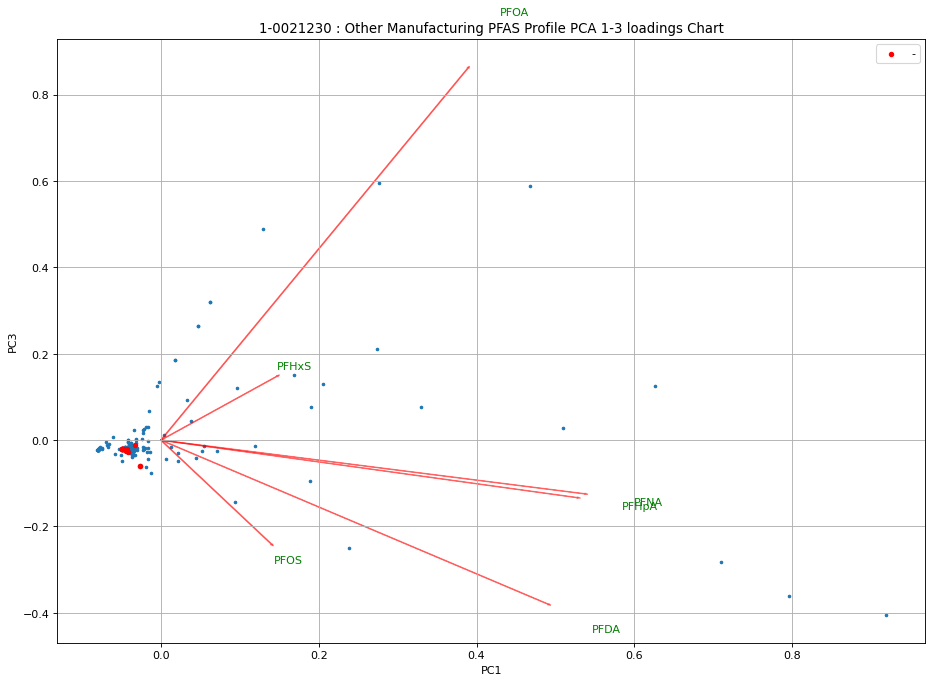

2-0020439
PC 1 Score Summary Statistics : count    18.000000
mean      0.029361
std       0.087299
min      -0.041703
25%      -0.036890
50%       0.000329
75%       0.058026
max       0.276654
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    18.000000
mean     -0.038868
std       0.013144
min      -0.072594
25%      -0.045596
50%      -0.035772
75%      -0.031162
max      -0.021563
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    18.000000
mean      0.158955
std       0.184071
min      -0.006440
25%       0.006419
50%       0.090309
75%       0.265021
max       0.594315
Name: PC 3, dtype: float64


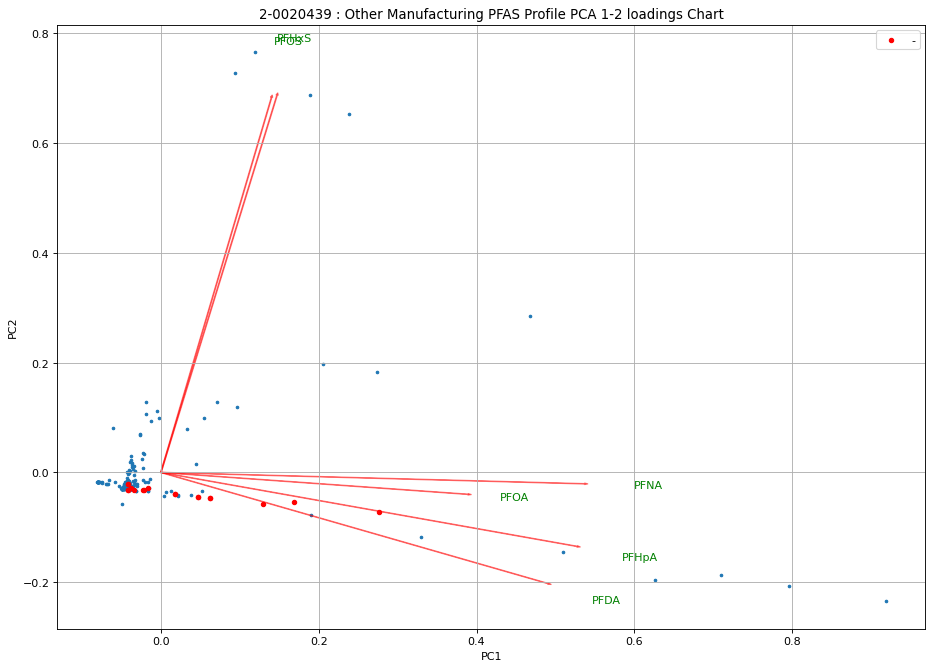

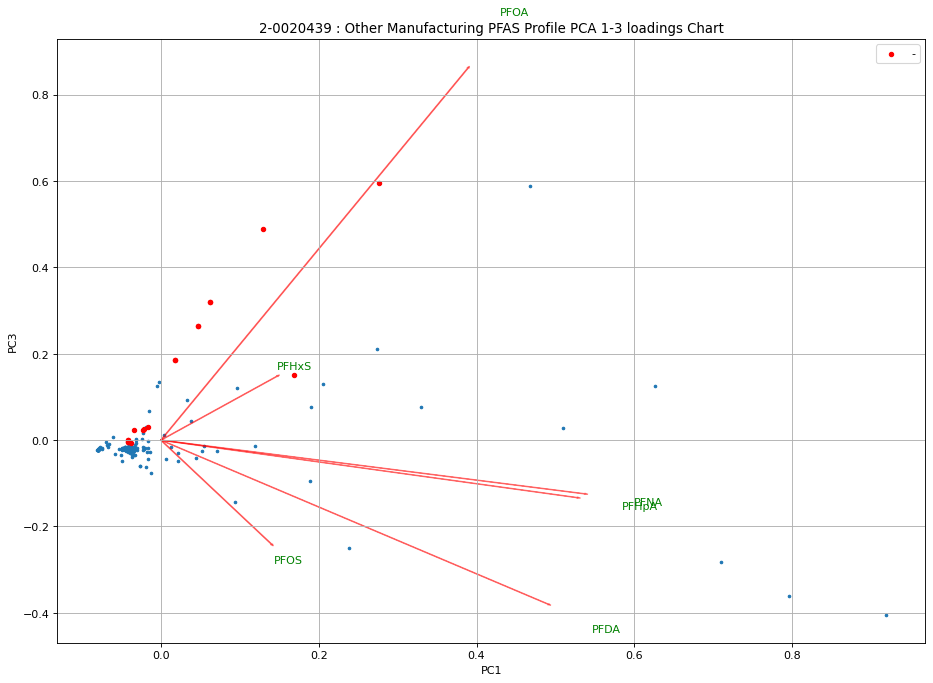

2-0021116
PC 1 Score Summary Statistics : count    6.000000
mean    -0.039140
std      0.011776
min     -0.045271
25%     -0.043913
50%     -0.043622
75%     -0.043282
max     -0.015147
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    6.000000
mean    -0.021277
std      0.003541
min     -0.027648
25%     -0.021299
50%     -0.020609
75%     -0.020547
max     -0.016740
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    6.000000
mean    -0.003807
std      0.035224
min     -0.021790
25%     -0.017331
50%     -0.017283
75%     -0.017175
max      0.067997
Name: PC 3, dtype: float64


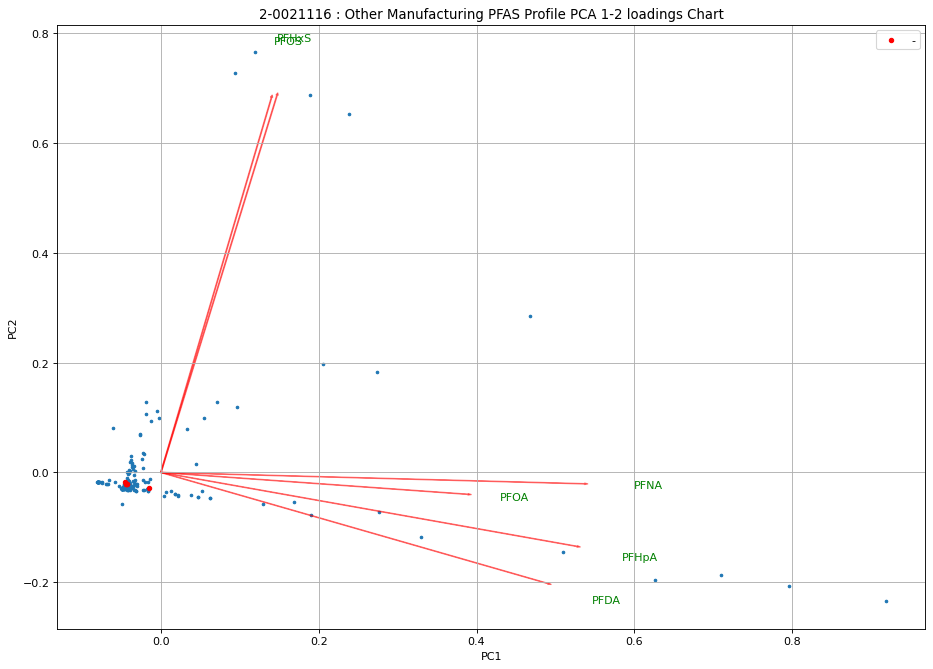

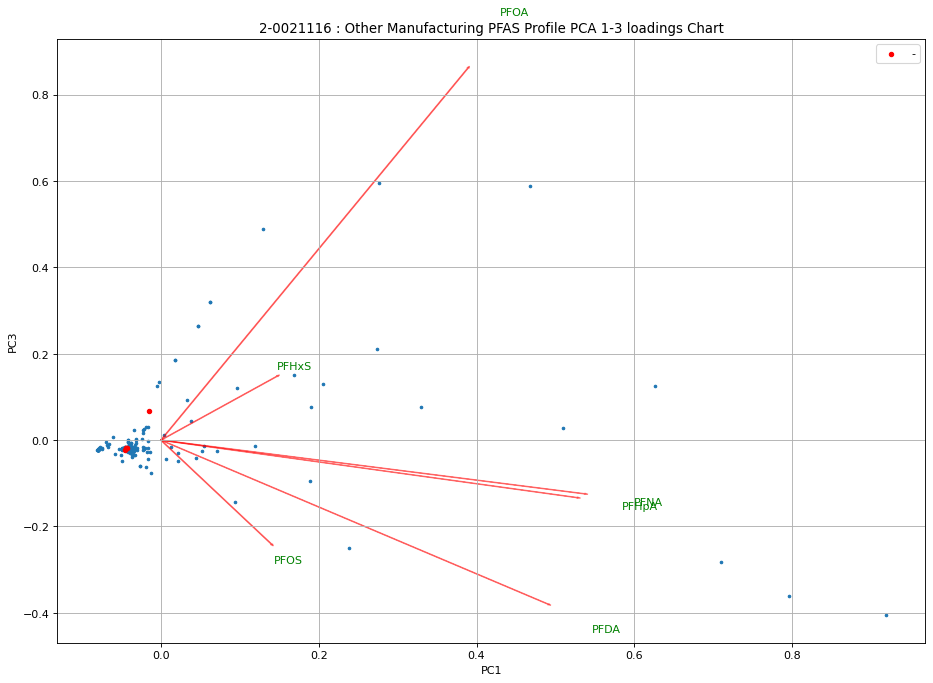

2-0021349
PC 1 Score Summary Statistics : count    20.000000
mean     -0.042871
std       0.005064
min      -0.048211
25%      -0.046655
50%      -0.043718
75%      -0.042646
max      -0.031005
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    20.000000
mean     -0.023258
std       0.006340
min      -0.033953
25%      -0.027500
50%      -0.024577
75%      -0.017881
max      -0.013227
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    20.000000
mean     -0.017098
std       0.006517
min      -0.024292
25%      -0.019865
50%      -0.017837
75%      -0.017426
max       0.001846
Name: PC 3, dtype: float64


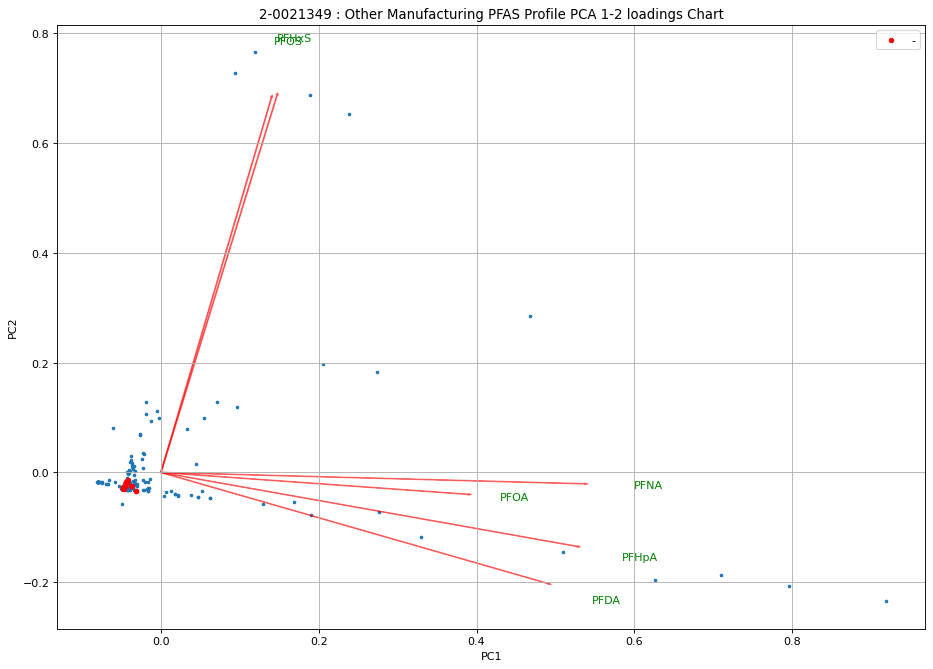

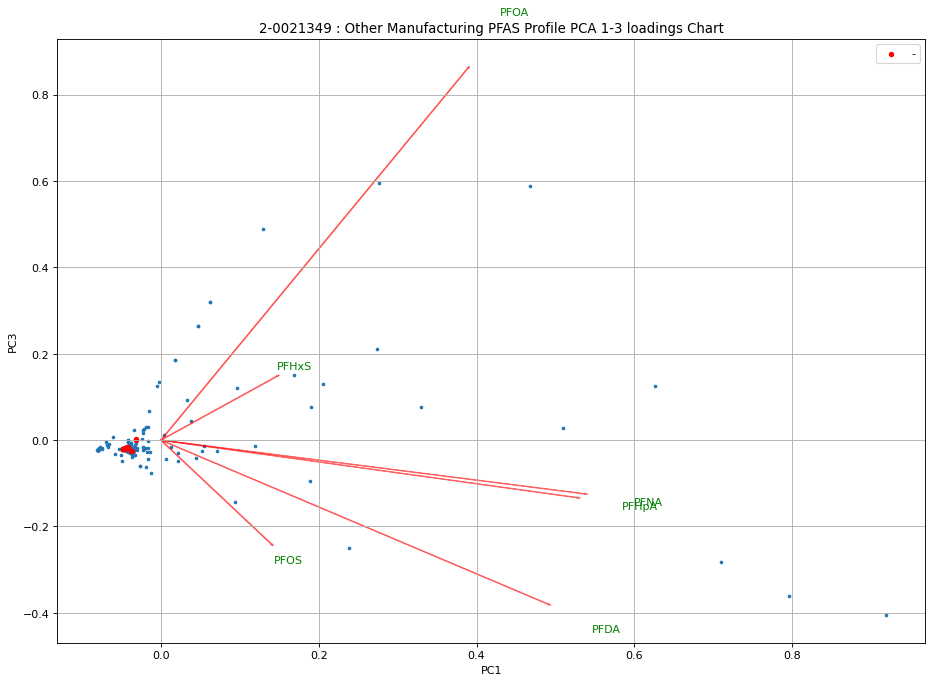

2-0021383
PC 1 Score Summary Statistics : count    2.000000
mean    -0.035335
std      0.001013
min     -0.036051
25%     -0.035693
50%     -0.035335
75%     -0.034977
max     -0.034619
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    2.000000
mean     0.010811
std      0.000471
min      0.010479
25%      0.010645
50%      0.010811
75%      0.010978
max      0.011144
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    2.000000
mean    -0.036729
std      0.003505
min     -0.039207
25%     -0.037968
50%     -0.036729
75%     -0.035490
max     -0.034250
Name: PC 3, dtype: float64


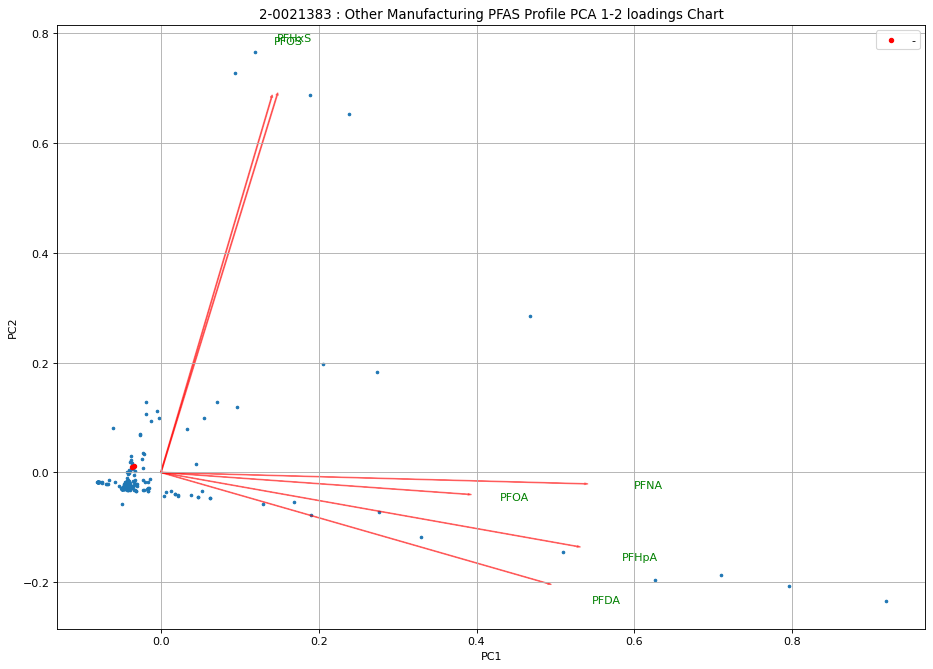

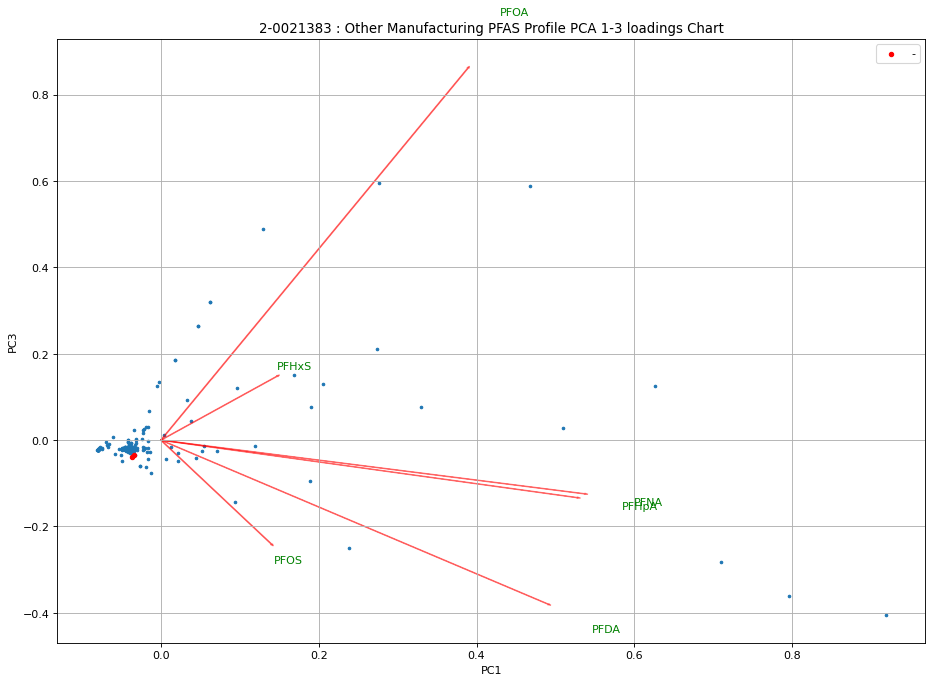

2-0021446
PC 1 Score Summary Statistics : count    2.000000
mean    -0.030781
std      0.016755
min     -0.042628
25%     -0.036705
50%     -0.030781
75%     -0.024857
max     -0.018933
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    2.000000
mean     0.059516
std      0.098485
min     -0.010123
25%      0.024697
50%      0.059516
75%      0.094336
max      0.129155
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    2.000000
mean     0.003936
std      0.037360
min     -0.022481
25%     -0.009273
50%      0.003936
75%      0.017145
max      0.030354
Name: PC 3, dtype: float64


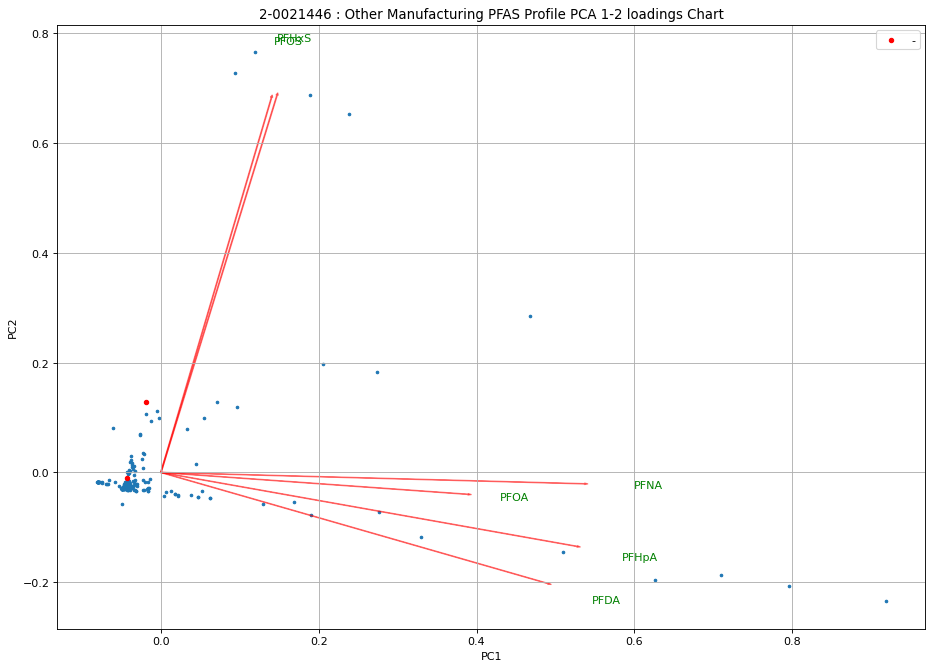

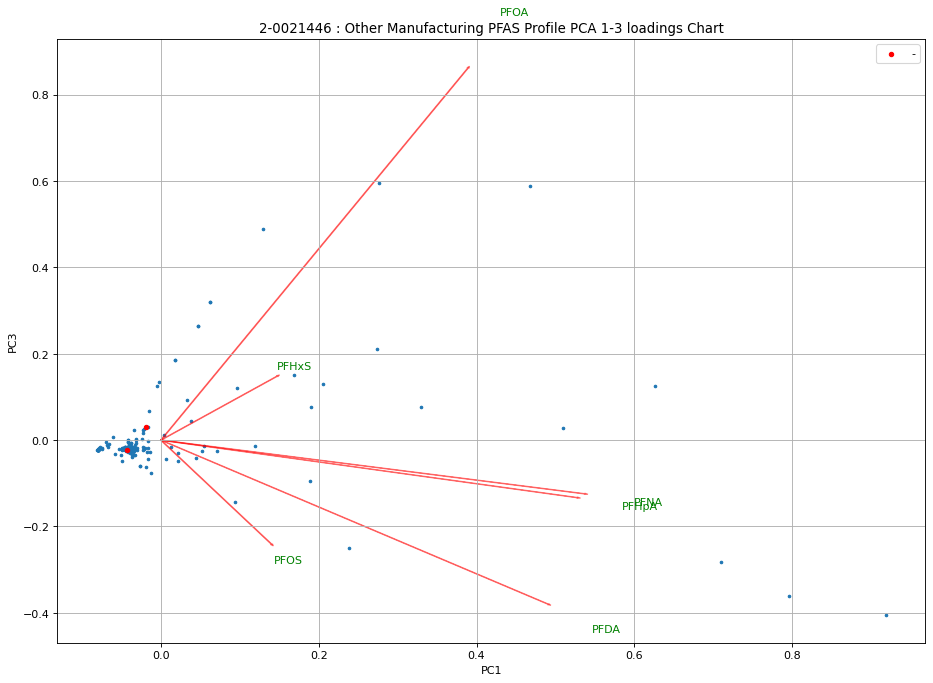

2-0021455
PC 1 Score Summary Statistics : count    5.000000
mean     0.001529
std      0.104998
min     -0.047155
25%     -0.045821
50%     -0.045815
75%     -0.042898
max      0.189334
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    5.000000
mean     0.123804
std      0.314866
min     -0.024352
25%     -0.023986
50%     -0.020165
75%      0.000773
max      0.686748
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    5.000000
mean    -0.033847
std      0.033702
min     -0.094005
25%     -0.022240
50%     -0.019223
75%     -0.017040
max     -0.016726
Name: PC 3, dtype: float64


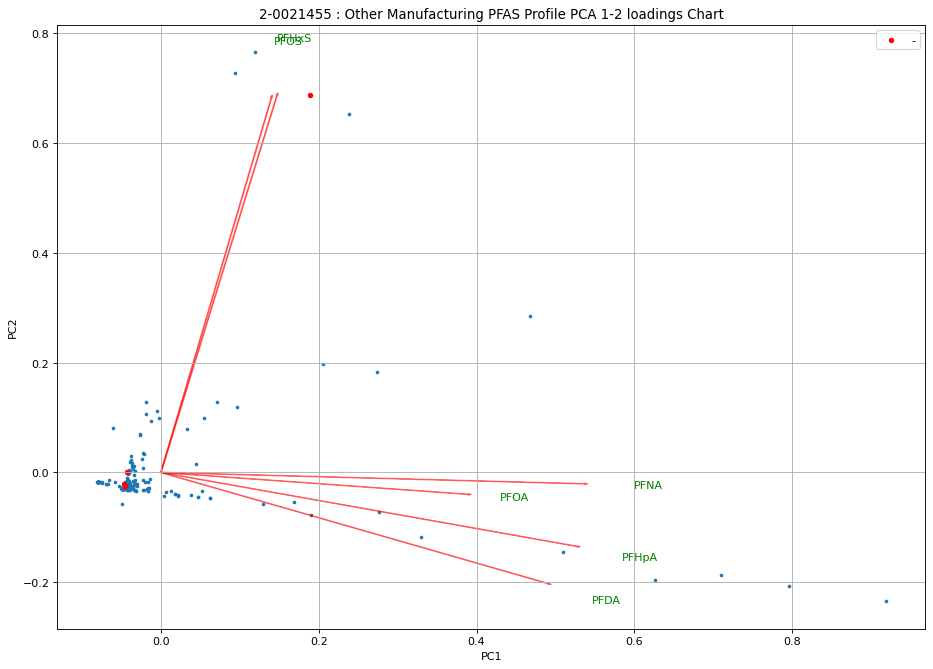

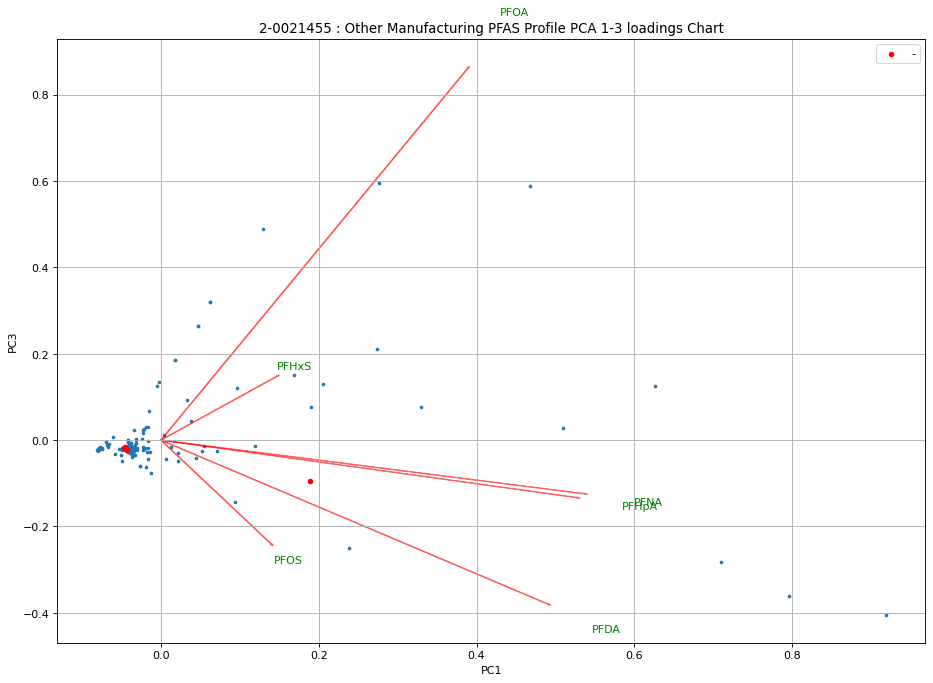

2-0021541
PC 1 Score Summary Statistics : count    17.000000
mean     -0.041073
std       0.009210
min      -0.049188
25%      -0.047499
50%      -0.046104
75%      -0.034734
max      -0.015877
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    17.000000
mean     -0.025669
std       0.011703
min      -0.034688
25%      -0.030273
50%      -0.028466
75%      -0.026870
max       0.017363
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    17.000000
mean     -0.024368
std       0.007197
min      -0.042767
25%      -0.027990
50%      -0.020740
75%      -0.019866
max      -0.016977
Name: PC 3, dtype: float64


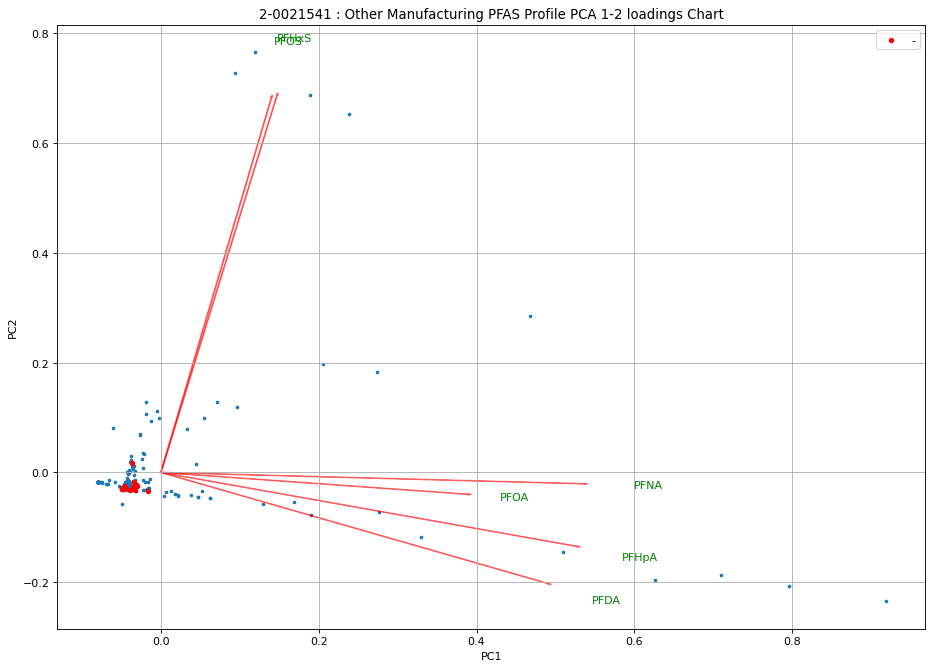

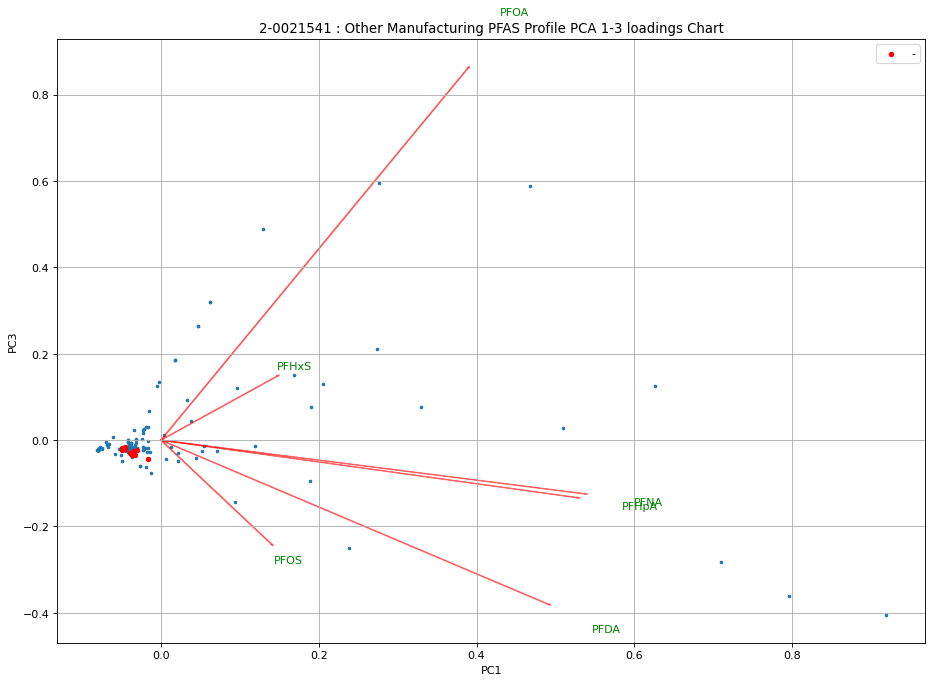

2-0021682
PC 1 Score Summary Statistics : count    10.000000
mean     -0.038280
std       0.010381
min      -0.048339
25%      -0.046825
50%      -0.040277
75%      -0.035417
max      -0.018651
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    10.000000
mean     -0.001501
std       0.040743
min      -0.027412
25%      -0.025320
50%      -0.018802
75%       0.005943
max       0.106034
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    10.000000
mean     -0.023335
std       0.014598
min      -0.063182
25%      -0.022906
50%      -0.019270
75%      -0.016710
max      -0.011657
Name: PC 3, dtype: float64


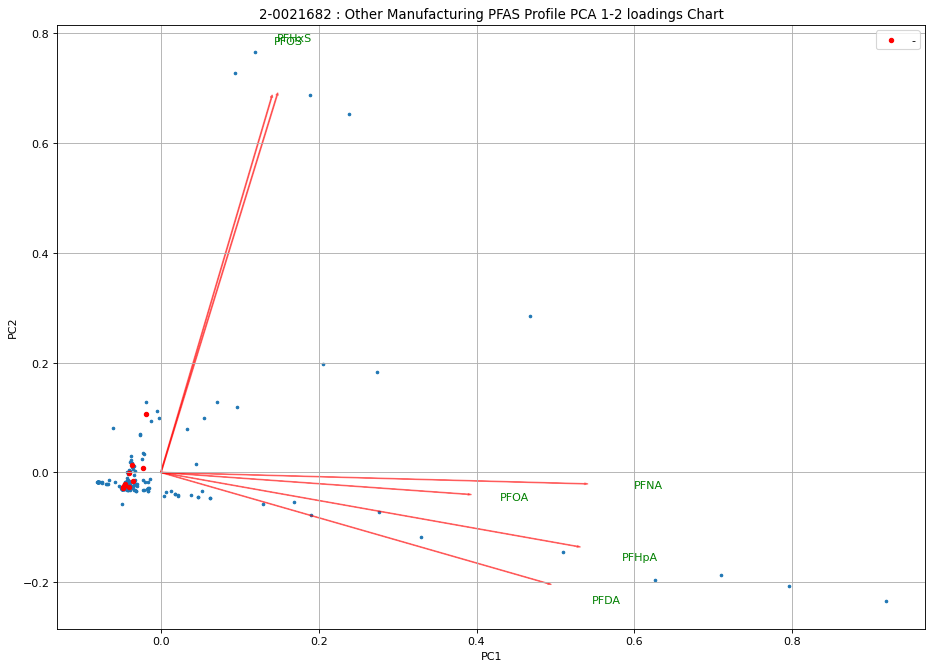

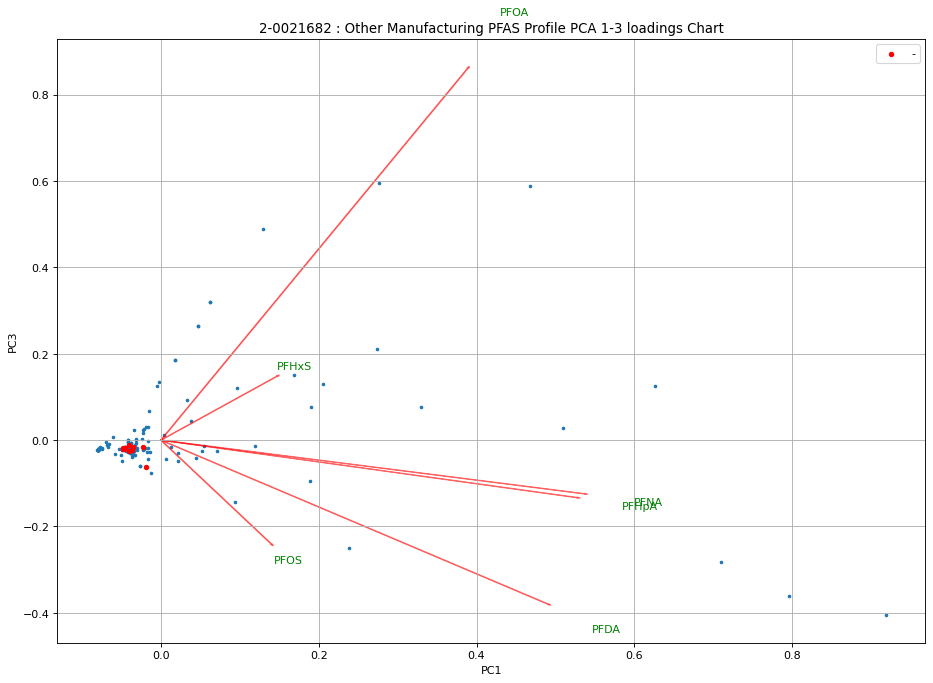

3-0036649
PC 1 Score Summary Statistics : count    30.000000
mean      0.066345
std       0.259288
min      -0.049188
25%      -0.039417
50%      -0.032029
75%      -0.014374
max       0.918601
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    30.000000
mean      0.019983
std       0.199634
min      -0.234705
25%      -0.027027
50%      -0.019938
75%       0.004320
max       0.765295
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    30.000000
mean     -0.058187
std       0.109603
min      -0.405685
25%      -0.022239
50%      -0.018781
75%      -0.015743
max       0.015371
Name: PC 3, dtype: float64


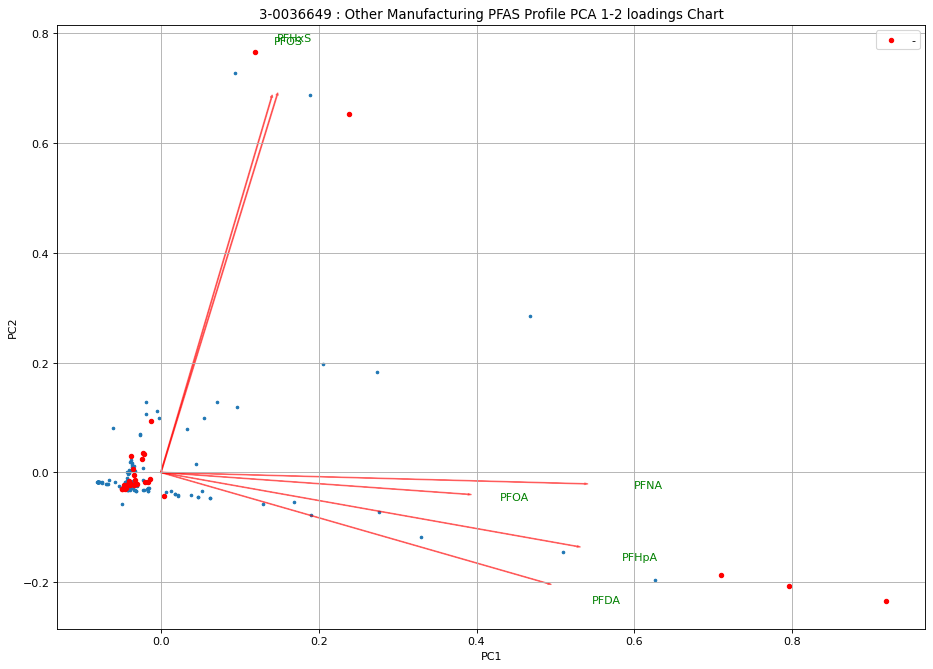

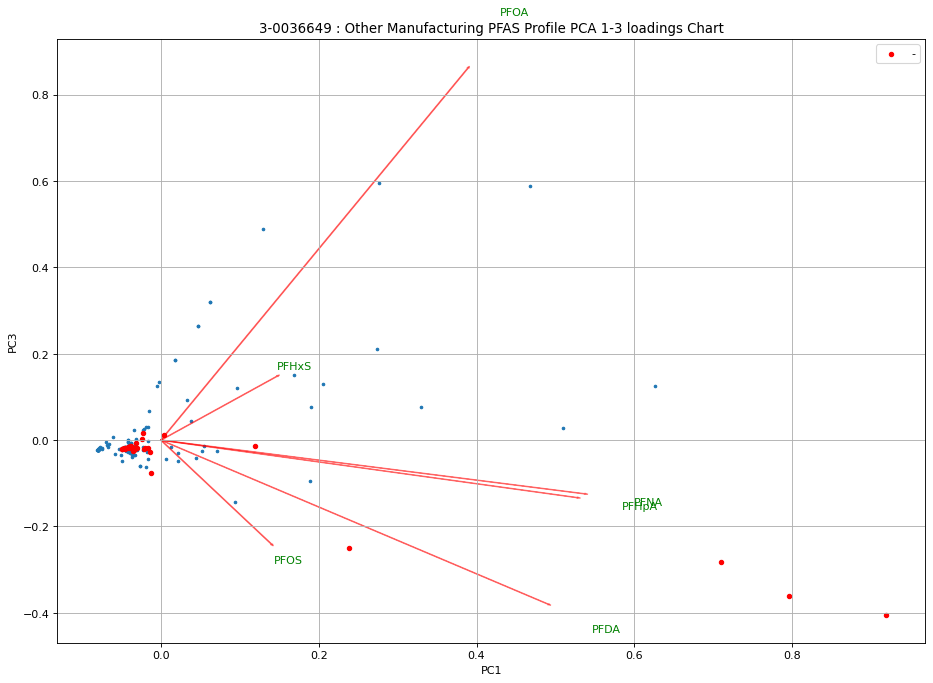

3-0036899
PC 1 Score Summary Statistics : count    23.000000
mean     -0.000966
std       0.127474
min      -0.079234
25%      -0.053422
50%      -0.040283
75%      -0.029765
max       0.467219
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    23.000000
mean      0.019534
std       0.079726
min      -0.030347
25%      -0.021969
50%      -0.017657
75%       0.017011
max       0.285100
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    23.000000
mean      0.016494
std       0.133741
min      -0.041938
25%      -0.022096
50%      -0.019260
75%      -0.013327
max       0.587629
Name: PC 3, dtype: float64


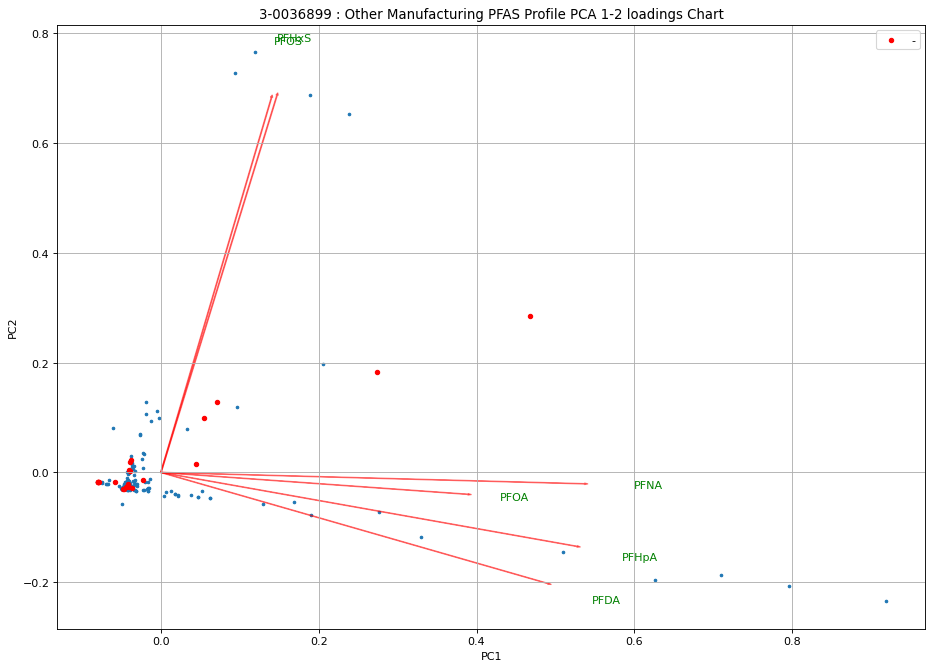

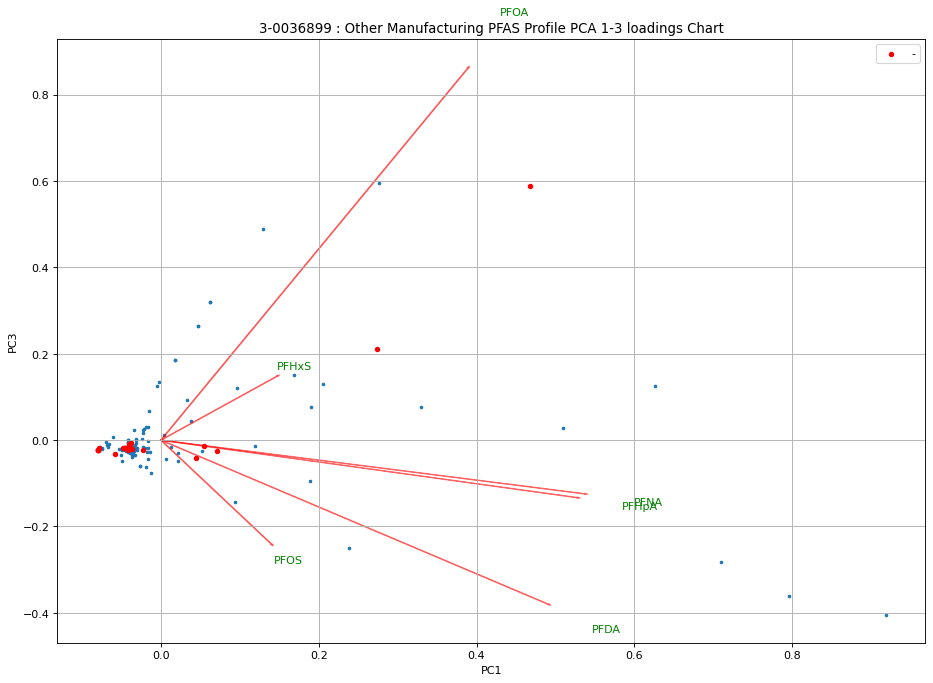

3-0036926
PC 1 Score Summary Statistics : count    17.000000
mean     -0.027228
std       0.079248
min      -0.079251
25%      -0.079215
50%      -0.074236
75%       0.012744
max       0.190405
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    17.000000
mean      0.023950
std       0.183688
min      -0.078113
25%      -0.029661
50%      -0.018302
75%      -0.018102
max       0.727203
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    17.000000
mean     -0.016262
std       0.042919
min      -0.143334
25%      -0.022014
50%      -0.021914
75%      -0.014947
max       0.076286
Name: PC 3, dtype: float64


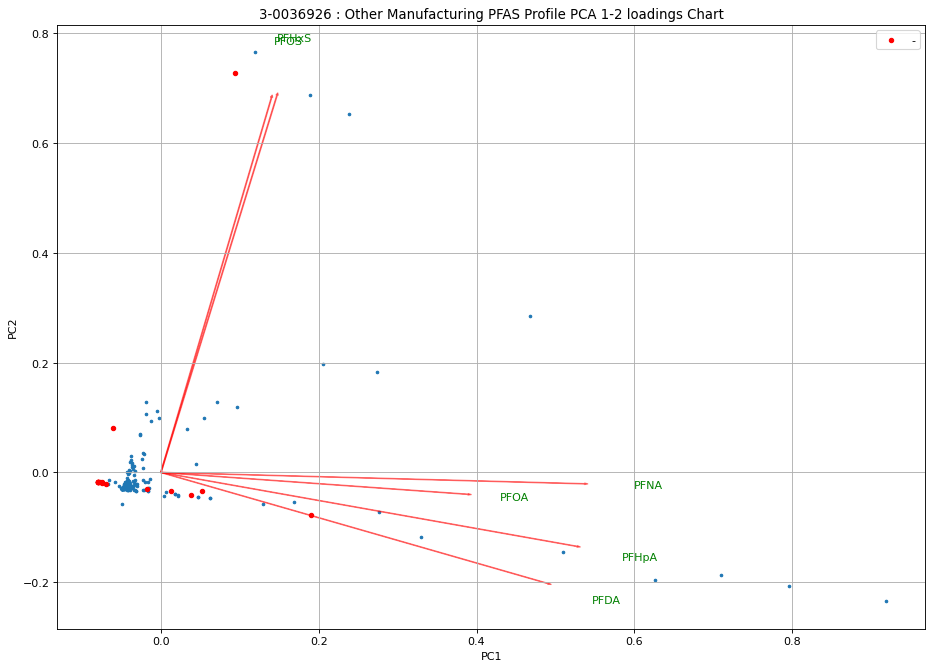

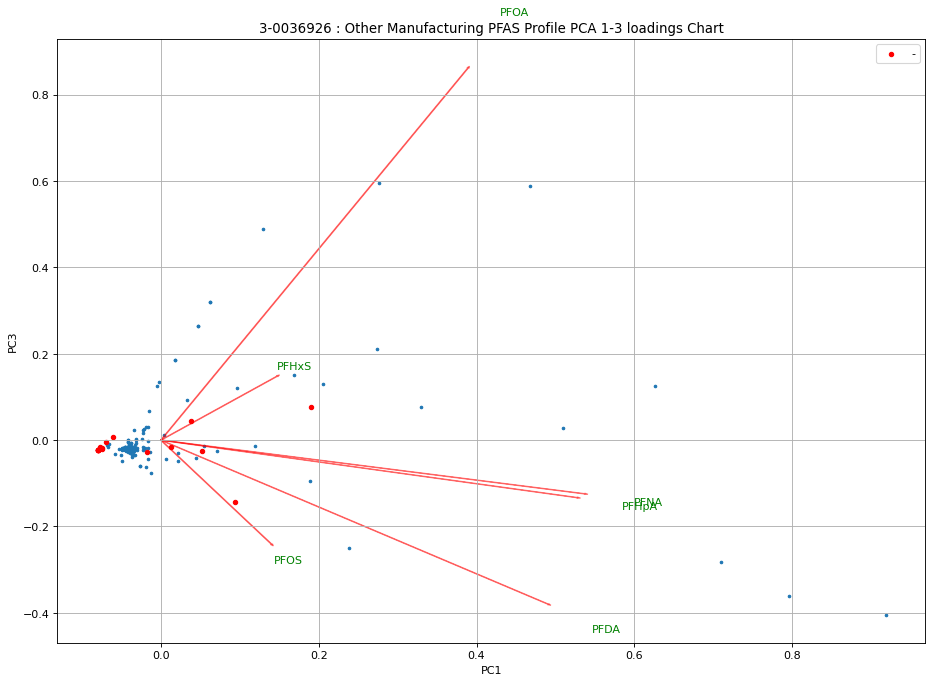

4-0028330
PC 1 Score Summary Statistics : count    25.000000
mean      0.036647
std       0.187877
min      -0.081399
25%      -0.079195
50%      -0.049934
75%       0.022223
max       0.626182
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    25.000000
mean     -0.011984
std       0.082963
min      -0.195973
25%      -0.036254
50%      -0.018302
75%      -0.017103
max       0.197028
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    25.000000
mean      0.016655
std       0.065269
min      -0.048978
25%      -0.022295
50%      -0.019673
75%       0.077674
max       0.134476
Name: PC 3, dtype: float64


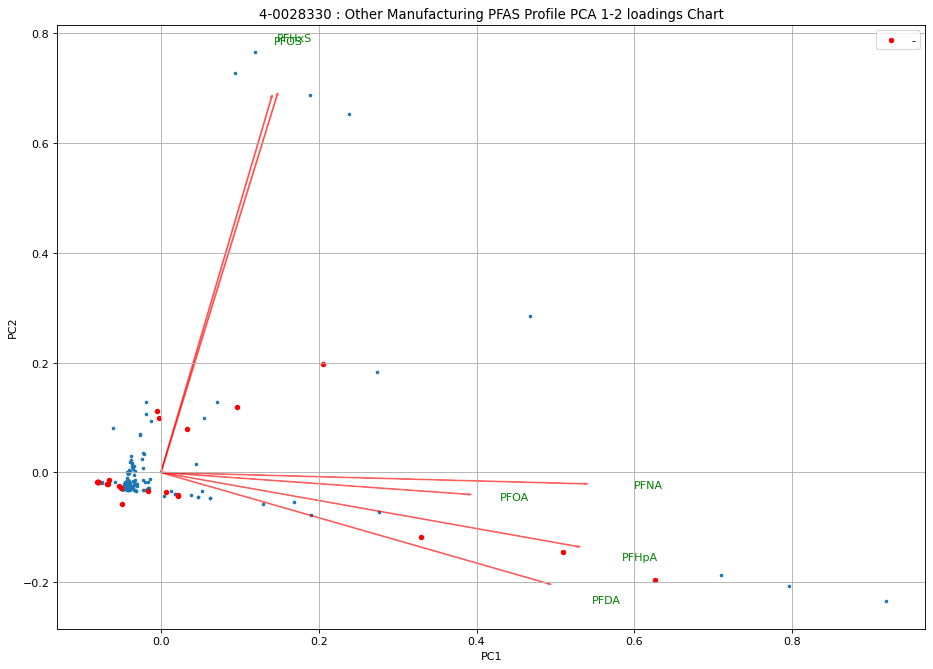

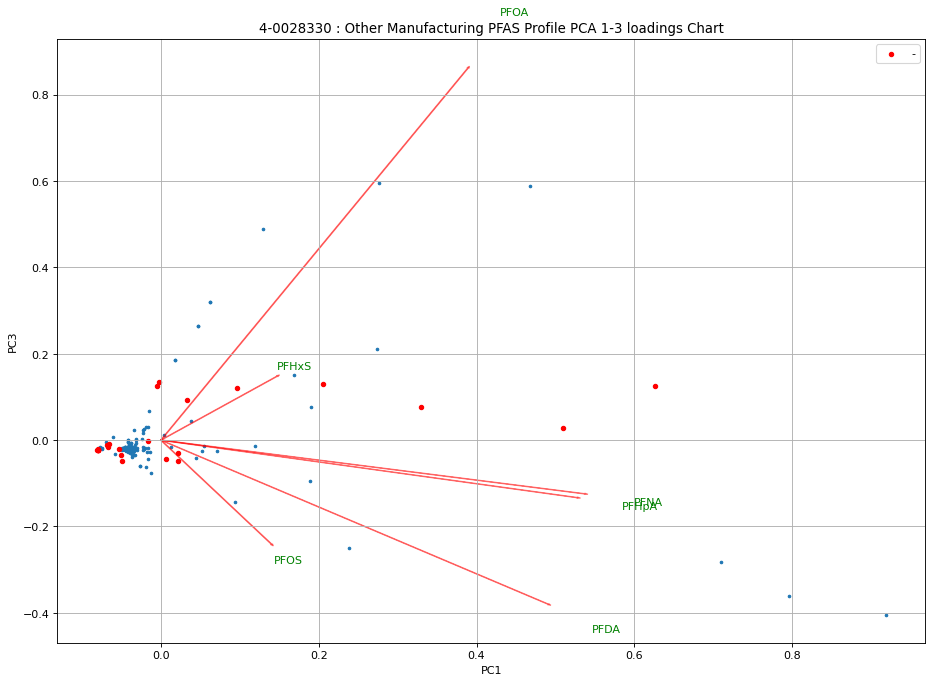

In [64]:
# Run PCA loading plot again. Then overlay scatter plot depicting samples for each cluster onto the loading plot.
for rtn in other_df['RTN'].unique():
    
    y_rtn_pca = pca_df[pca_df['RTN']==rtn]
    y_rtn_pca_x = y_rtn_pca.iloc[:,0]
    y_rtn_pca_y = y_rtn_pca.iloc[:,1]
    y_rtn_pca_z = y_rtn_pca.iloc[:,2]
    
    print(rtn)
    print('PC 1 Score Summary Statistics :', (y_rtn_pca_x * scalex).describe())
    print('PC 2 Score Summary Statistics :', (y_rtn_pca_y * scaley).describe())
    print('PC 3 Score Summary Statistics :', (y_rtn_pca_z * scalez).describe())
    
    utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(other_df[pfas_vars].columns), title = f"{rtn} : Other Manufacturing PFAS Profile PCA 1-2 loadings Chart")
    
    plt.scatter(y_rtn_pca_x * scalex, y_rtn_pca_y * scaley, s=15, c='red', label=f'{rtn[1]}')
        
    plt.legend()
    plt.show()

    utils.pca_loadings_plot(Principal_components[:,(0,2)],np.transpose(pca.components_[(0,2), :]),list(other_df[pfas_vars].columns), title = f"{rtn} : Other Manufacturing PFAS Profile PCA 1-3 loadings Chart")


    plt.scatter(y_rtn_pca_x * scalex, y_rtn_pca_z * scalez, s=15, c='red', label=f'{rtn[1]}')
    plt.ylabel("PC{}".format(3))

    plt.legend()
    plt.show()

PC 1 - Mixed Industrial Applications. Consistent with RTNs and with URI MVA study

****

### Hierarchical Clustering (HC)
* HC via "Ward" method and euclidean distance.
* Ward method minimizes within-cluster variance.

In [112]:
# other_df.head(50)

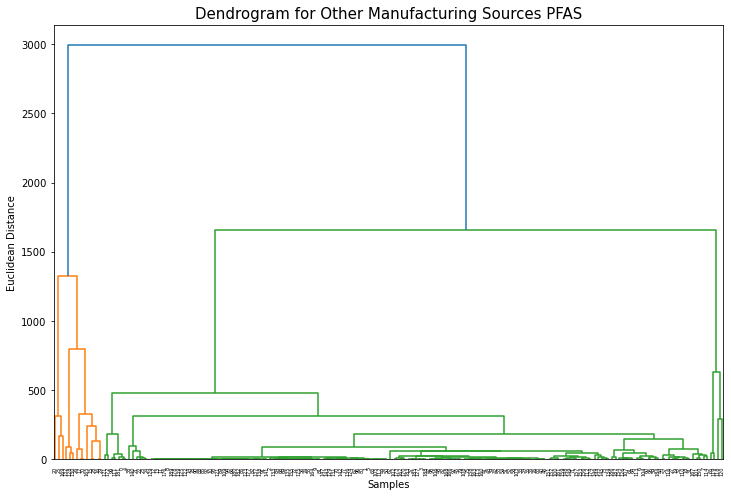

In [36]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(other_df[pfas_vars], method='ward'))
plt.title("Dendrogram for Other Manufacturing Sources PFAS", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()

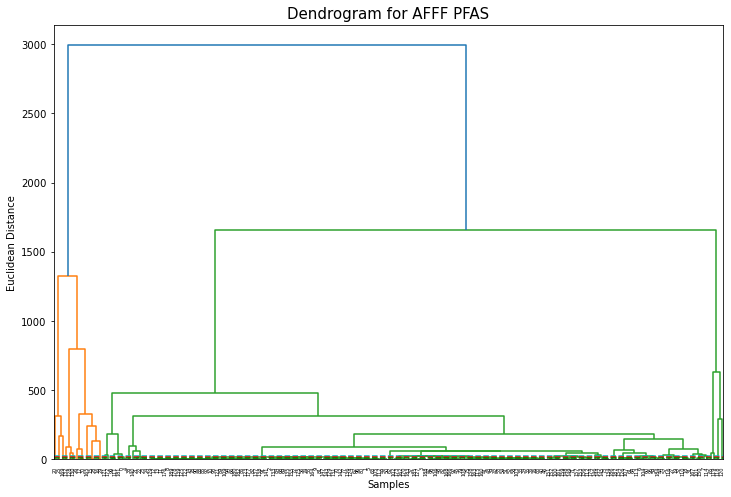

In [37]:
# Determine the optimal # of clusters using the dendrogram.
# Look for the longest vertical line(s) that does not cross another horizontal line.
# That would be the blue line on the left. Hence, if we choose a Euclidean distance
# of 4, we would get three (3) clusters (see cyan dotted line below).
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(other_df[pfas_vars], method='ward'))
plt.title("Dendrogram for AFFF PFAS", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.axhline(y=25, color='c', linestyle='--')
# Other lines, but might be overkill.
plt.axhline(y=20, color='r', linestyle='--')
plt.axhline(y=10, color='g', linestyle='--')
# plt.axhline(y=2.25, color='b', linestyle='--')
plt.show()

In [115]:
# Predict clusters using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

numClusters = 4
# Based on analysis of dendrogram above, we will select three (3) clusters.
clusterHC = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')  
y_hc = clusterHC.fit_predict(other_df[pfas_vars])

In [116]:
# Visualize clusters in 2D scatter plot. Can only pick up to three compounds at a time,
# but will only plot the first two on the list for 2D scatter plot.
# test = cluster.labels_
y_hc_loc0 = other_df.iloc[y_hc==0]
y_hc_loc1 = other_df.iloc[y_hc==1]
y_hc_loc2 = other_df.iloc[y_hc==2]
y_hc_loc3 = other_df.iloc[y_hc==3]

pfas_col_num = [3, 4, 5]
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_names)

data0 = y_hc_loc0[pfas_col_names]
data1 = y_hc_loc1[pfas_col_names]
data2 = y_hc_loc2[pfas_col_names]
data3 = y_hc_loc3[pfas_col_names]
# print(data0)

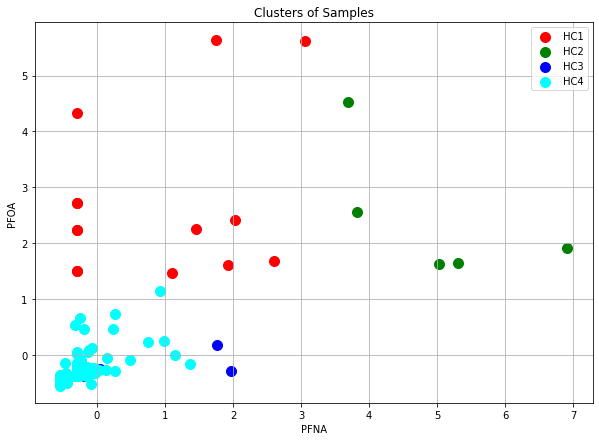

In [117]:
# Plot clusters in 2D
plt.figure(figsize=(10, 7))

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
plt.scatter(data0.iloc[:, 0], data0.iloc[:, 1], s=100, c='red', label='HC1')
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=100, c='green', label='HC2')
plt.scatter(data2.iloc[:, 0], data2.iloc[:, 1], s=100, c='blue', label='HC3')
plt.scatter(data3.iloc[:, 0], data3.iloc[:, 1], s=100, c='cyan', label='HC4')

plt.title("Clusters of Samples")
plt.xlabel(pfas_col_names[0])
plt.ylabel(pfas_col_names[1])
plt.legend()
plt.grid(True)

plt.show()

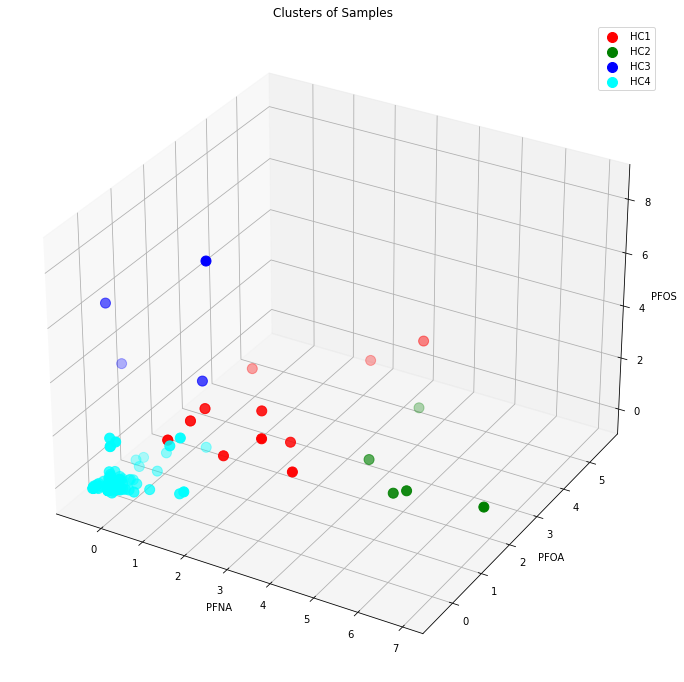

In [118]:
# Plot clusters in 3D
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection ="3d")

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
ax.scatter3D(data0.iloc[:, 0], data0.iloc[:, 1], data0.iloc[:, 2], s=100, c='red', label='HC1')
ax.scatter3D(data1.iloc[:, 0], data1.iloc[:, 1], data1.iloc[:, 2], s=100, c='green', label='HC2')
ax.scatter3D(data2.iloc[:, 0], data2.iloc[:, 1], data2.iloc[:, 2], s=100, c='blue', label='HC3')
ax.scatter3D(data3.iloc[:, 0], data3.iloc[:, 1], data3.iloc[:, 2], s=100, c='cyan', label='HC4')

plt.title("Clusters of Samples")
plt.legend()
ax.set_xlabel(pfas_col_names[0])
ax.set_ylabel(pfas_col_names[1])
ax.set_zlabel(pfas_col_names[2])

plt.show()

In [119]:
# Set up box and whisker plots for each cluster for visualizing the profiles.
pfas_col_num = np.arange(len(pfas_vars))
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_col_names)

# median_cluster0 = y_hc_loc0[pfas_col_names].median(axis=0)
# median_cluster1 = y_hc_loc1[pfas_col_names].median(axis=0)
# median_cluster2 = y_hc_loc2[pfas_col_names].median(axis=0)

# mean_cluster0 = y_hc_loc0[pfas_col_names].mean(axis=0)
# mean_cluster1 = y_hc_loc1[pfas_col_names].mean(axis=0)
# mean_cluster2 = y_hc_loc2[pfas_col_names].mean(axis=0)

# print(median_cluster0)
# print(mean_cluster0)
# print(y_hc_loc2[pfas_col_names].max(axis=0))

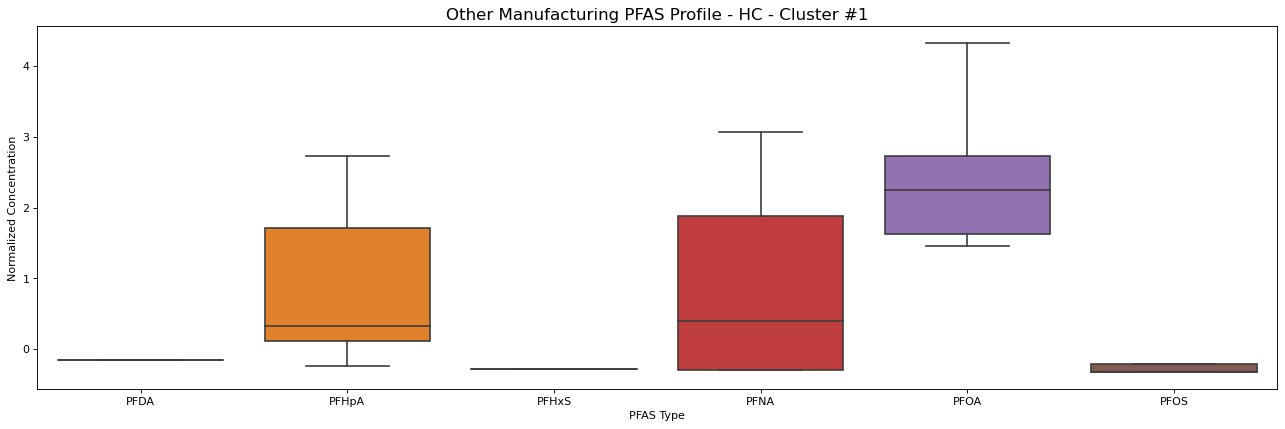

In [120]:
plt.figure(figsize=(20, 6), dpi=80)
# plt.ylabel('Normalized Concentration')
# plt.xlabel('PFAS Type')
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #1', fontsize=15)

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc0[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
# Set all clusters to have the same y-axis scaling (for better comparison)
# plt.ylim(0, 1.05)
plt.show()

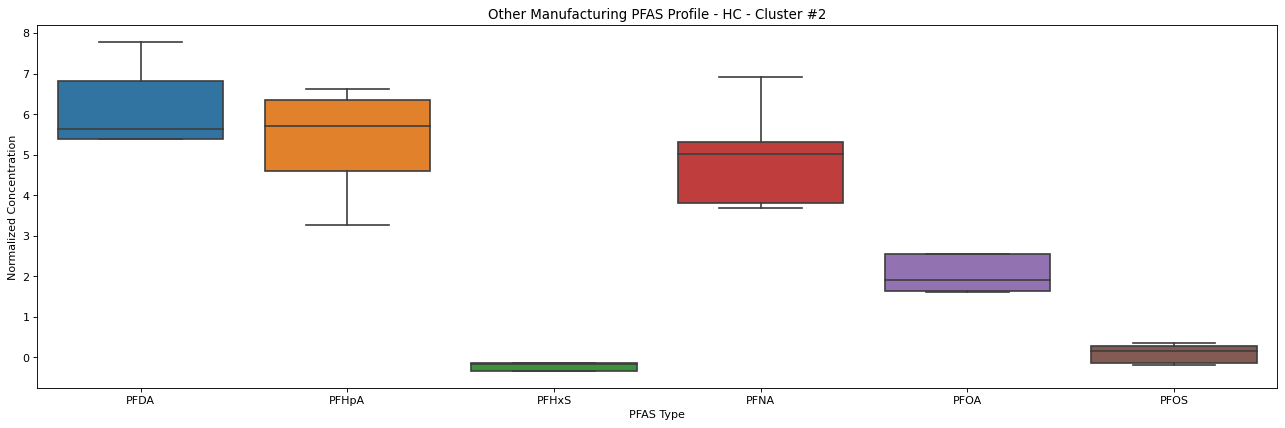

In [121]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #2')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc1[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

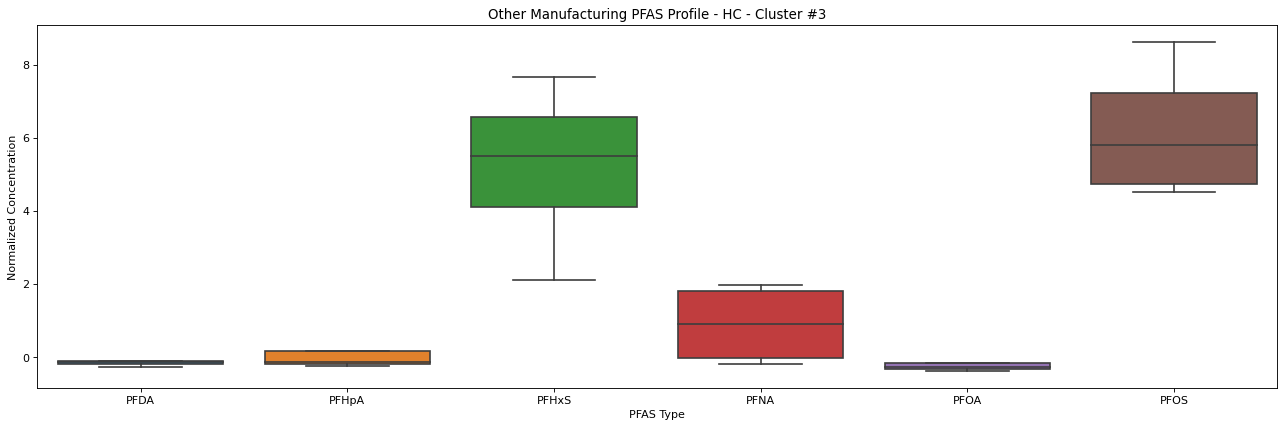

In [122]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #3')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc2[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

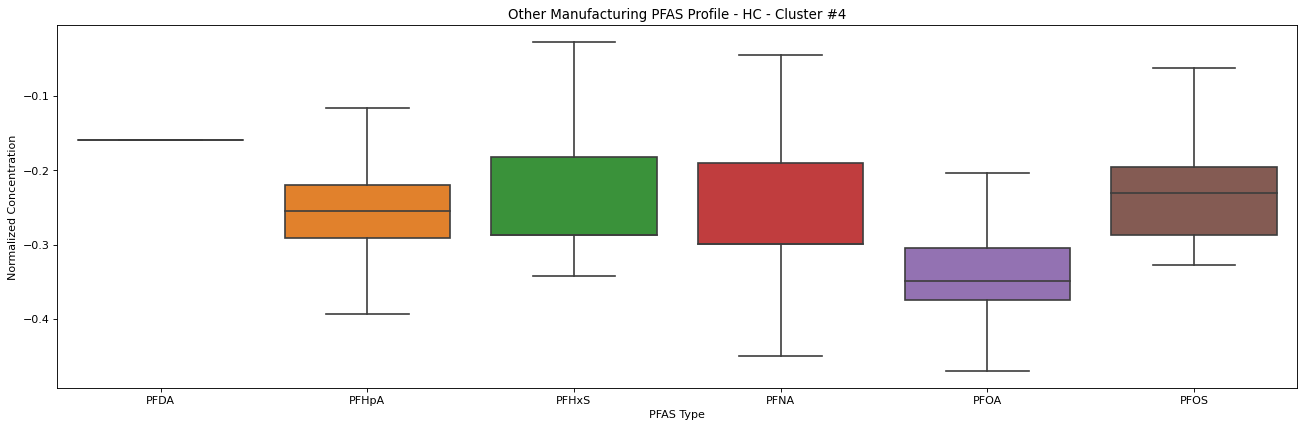

In [123]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #4')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc3[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

****

### Compare PCA to HC
* Overlay samples for each clusters onto the PCA loading plot

In [124]:
# Need to scale values based on ALL values not only those from individual clusters because original
# PCA loading plot is based on all values.
pca_df_x = pca_df.iloc[:,0]
pca_df_y = pca_df.iloc[:,1]
scalex = 1.0/(pca_df_x.max() - pca_df_x.min())
scaley = 1.0/(pca_df_y.max() - pca_df_y.min())

y_hc_loc0_pca = pca_df.iloc[y_hc==0]
y_hc_loc1_pca = pca_df.iloc[y_hc==1]
y_hc_loc2_pca = pca_df.iloc[y_hc==2]
y_hc_loc3_pca = pca_df.iloc[y_hc==3]

# print(type(Principal_components))
# print(type(y_hc_loc0_pca))
y_hc_loc0_pca_x = y_hc_loc0_pca.iloc[:,0]
y_hc_loc0_pca_y = y_hc_loc0_pca.iloc[:,1]
y_hc_loc1_pca_x = y_hc_loc1_pca.iloc[:,0]
y_hc_loc1_pca_y = y_hc_loc1_pca.iloc[:,1]
y_hc_loc2_pca_x = y_hc_loc2_pca.iloc[:,0]
y_hc_loc2_pca_y = y_hc_loc2_pca.iloc[:,1]
y_hc_loc3_pca_x = y_hc_loc3_pca.iloc[:,0]
y_hc_loc3_pca_y = y_hc_loc3_pca.iloc[:,1]
# print(y_hc_loc0_pca_x)
# print(y_hc_loc0_pca_y)
# y_hc_loc0_pca_x = y_hc_loc0_pca['PC1']
# y_hc_loc0_pca_y = y_hc_loc0_pca[:,1]

# print(scalex)
# print(scaley)
# print(y_hc_loc0_pca_x * scalex)
# print(y_hc_loc0_pca_y * scaley)

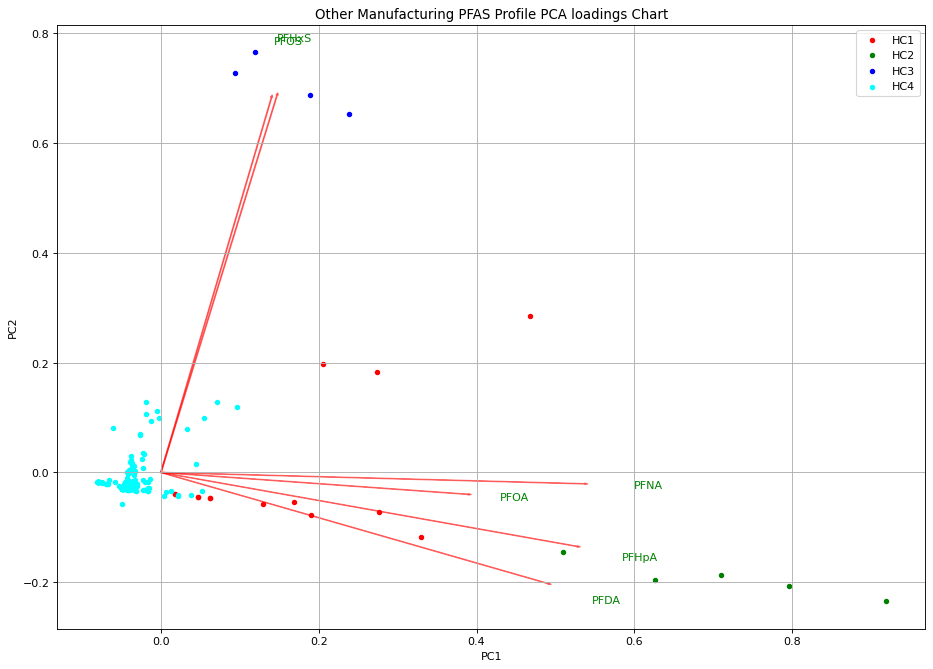

In [125]:
# Run PCA loading plot again. Then overlay scatter plot depicting samples for each cluster onto the loading plot.
utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(other_df[pfas_vars].columns), title = "Other Manufacturing PFAS Profile PCA loadings Chart")
plt.scatter(y_hc_loc0_pca_x * scalex, y_hc_loc0_pca_y * scaley, s=15, c='red', label='HC1')
plt.scatter(y_hc_loc1_pca_x * scalex, y_hc_loc1_pca_y * scaley, s=15, c='green', label='HC2')
plt.scatter(y_hc_loc2_pca_x * scalex, y_hc_loc2_pca_y * scaley, s=15, c='blue', label='HC3')
plt.scatter(y_hc_loc3_pca_x * scalex, y_hc_loc3_pca_y * scaley, s=15, c='cyan', label='HC4')
plt.legend()
plt.show()

****

### Spatial Inference of Hierarchical Cluster
* Create layer of locations by cluster

In [86]:
source_locations = pd.read_parquet('../../../data/disposal_sites/PFAS_Sites_2021-11-07_geocoded.parquet')

In [87]:
other_df['hclusters'] = y_hc

In [88]:
other_df['RTN'] = utils.extract_rtn(df = other_df,
                                    report_col = 'report')

In [89]:
other_df = other_df.merge(source_locations[['RTN', 'lat', 'lon']], on = 'RTN')

In [90]:
other_df = utils.add_wiggliness_for_spatial_interpolation(df = other_df,
                                                          lat_col = 'lat',
                                                          lon_col = 'lon')

In [44]:
other_gdf = gpd.GeoDataFrame(
    other_df, 
    geometry=gpd.points_from_xy(other_df.lon, other_df.lat),
    crs={"init":"EPSG:4326"})

/anaconda3/envs/py38-gis/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [39]:
# other_gdf.to_file('../../../data/modeling_data/source_attribution/profiling/other_clusters.geojson', driver = 'GeoJSON')